In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random

train_dir = os.getcwd() + "/../train/"
train_files = os.listdir(train_dir)

bad_imgs_path = os.path.join(os.getcwd(), "badimgs.txt")
with open(bad_imgs_path, "r") as f:
    bad_imgs = {line.strip() for line in f if line.strip()}

# UTILS

def get_rand_img_path():
    return train_dir + random.choice(train_files)

def get_img(label):
    path = os.path.join(train_dir,f"{label}-0.png")
    img = cv2.imread(path)
    return img

def get_label(img_path):
    filename = os.path.basename(img_path)
    label = filename.split('-')[0]
    return label

def get_rand_img():
    path = get_rand_img_path()
    label = get_label(path)
    img = cv2.imread(path)
    return img, label

def show_img(img, title=None):
    plt.figure()
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

## SAMPLE CAPTCHA

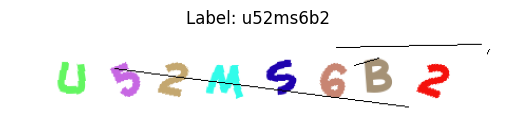

In [2]:
img, label = get_rand_img()

show_img(img, title=f"Label: {label}")

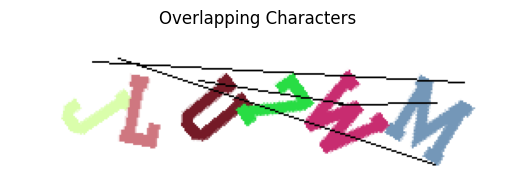

In [8]:
label = "jlu7wm"
img = get_img(label)

show_img(img, "Overlapping Characters")

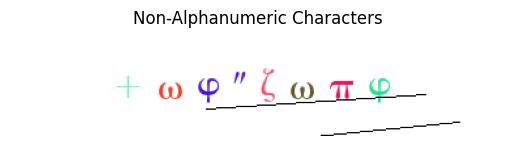

In [7]:
label = "1vw0zvpw"
img = get_img(label)

show_img(img, "Non-Alphanumeric Characters")

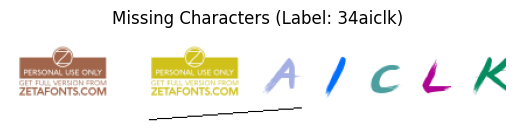

In [14]:
label = "34aiclk"
img = get_img(label)

show_img(img, "Missing Characters (Label: 34aiclk)")

In [17]:
def remove_lines(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    show_img(gray, "Grayscale")
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV)
    show_img(mask, "Binary Inverse Mask")
    # Remove lines
    removed = cv2.inpaint(img, mask, 3, cv2.INPAINT_NS)
    show_img(removed, "Cleaned")
    return removed

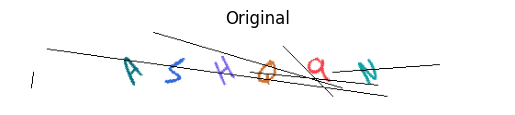

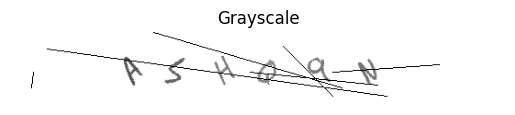

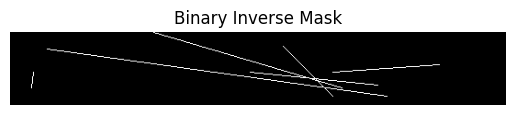

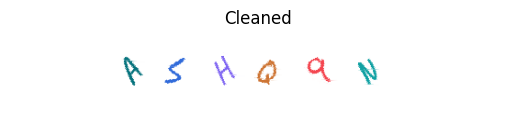

In [25]:
img, label = get_rand_img()
show_img(img, "Original")
img = remove_lines(img)

In [3]:
def analyze_images(dir, bad_imgs):
    stats = {
        "widths": [], "heights": [], "means": [], "stds": []
    }

    for file in os.listdir(dir):
        if file in bad_imgs:
            continue
        img_path = os.path.join(dir, file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        stats["heights"].append(img.shape[0])
        stats["widths"].append(img.shape[1])
        stats["means"].append(np.mean(img))
        stats["stds"].append(np.std(img))

    return stats

In [5]:
stats = analyze_images(train_dir, bad_imgs)

## Average Brightness Distribution

- The histogram of average image brightness shows a strong peak around 240–250, indicating that the majority of captcha images are very bright
- The distribution tapers off toward lower brightness values, meaning there are fewer darker images in the dataset

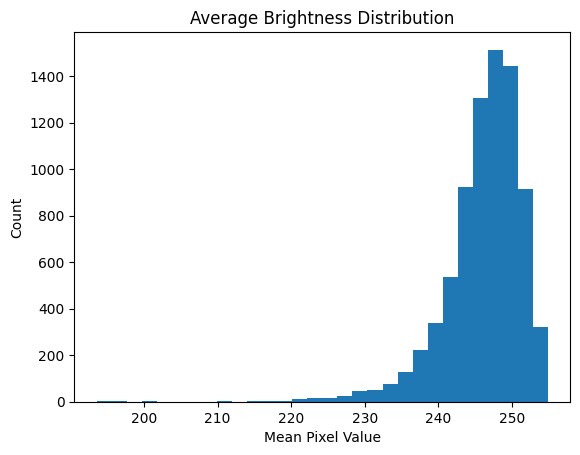

In [6]:
plt.hist(stats["means"], bins=30)
plt.title("Average Brightness Distribution")
plt.xlabel("Mean Pixel Value")
plt.ylabel("Count")
plt.show()

## Character Distribution

- The character frequency analysis shows that only a subset of alphanumeric characters appears in the dataset, rather than the full set of letters and digits 
- Among the characters that are present, the distribution is relatively even, indicating that no particular character dominates the dataset

### Interpretation
- This even distribution is beneficial for model training, as it reduces bias toward certain characters
- However, the absence of some characters means the model may not generalize to unseen characters unless augmented or supplemented with additional data

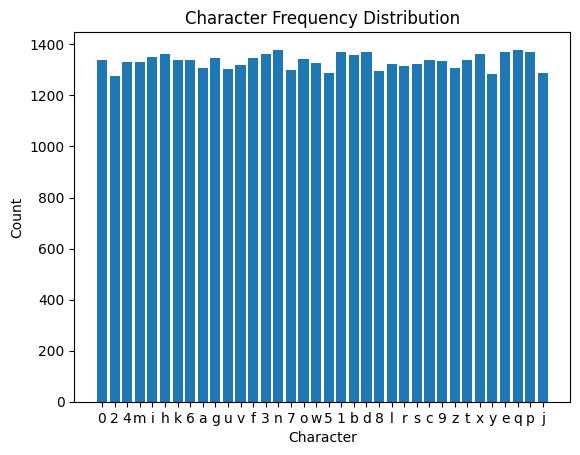

In [8]:
from collections import Counter

def get_character_distribution(train_files):
    char_counts = Counter()
    for file in train_files:
        label = file.split('-')[0]
        char_counts.update(label)
    return char_counts

char_dist = get_character_distribution(train_files)
plt.bar(char_dist.keys(), char_dist.values())
plt.title("Character Frequency Distribution")
plt.xlabel("Character")
plt.ylabel("Count")
plt.show()

## Captcha Length Distribution

- The histogram of captcha lengths shows that the captchas in the dataset range from 4 to 9 characters
- The distribution across this range is relatively even, meaning there is no strong bias toward any particular captcha length

### Interpretation
- This even distribution is advantageous for model training, as it ensures the network sees captchas of varying lengths
- However, the presence of multiple lengths suggests that your preprocessing pipeline should handle variable-length labels

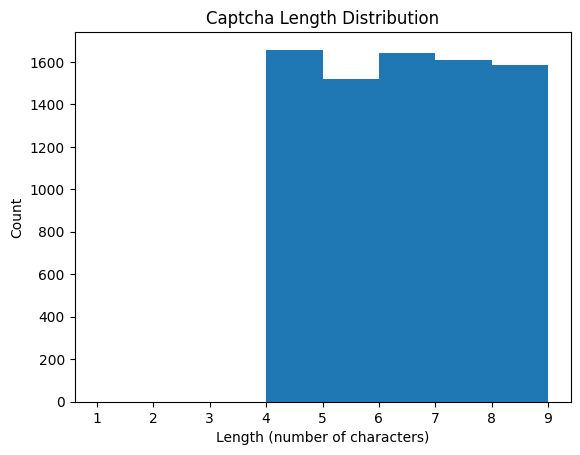

In [9]:
def get_length_distribution(train_files):
    lengths = [len(file.split('-')[0]) for file in train_files]
    plt.hist(lengths, bins=range(1, max(lengths)+2))
    plt.title("Captcha Length Distribution")
    plt.xlabel("Length (number of characters)")
    plt.ylabel("Count")
    plt.show()
    return lengths

lengths = get_length_distribution(train_files)

## Image Contrast Distribution
- The histogram of image contrast (measured as the standard deviation of pixel values) forms a normal bell-shaped curve with a peak around 40

### Interpretation
- Most images have a moderate level of contrast, suggesting that text in the captchas is generally distinguishable from the background
- The bell-shaped curve indicates consistent contrast across the dataset, with few very low-contrast (dull) or very high-contrast (sharp) outliers
- This consistency reduces the need for aggressive contrast normalization during preprocessing, though small adjustments (like histogram equalization) could still improve model performance

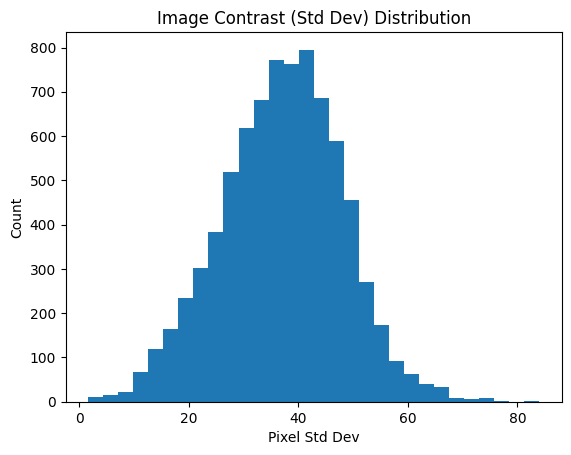

In [10]:
plt.hist(stats["stds"], bins=30)
plt.title("Image Contrast (Std Dev) Distribution")
plt.xlabel("Pixel Std Dev")
plt.ylabel("Count")
plt.show()

In [2]:
import pandas as pd
segmentation_df = pd.read_csv("segmentation.csv")
segmentation_df

,segmentation_method,accuracy
0,log_gabor,0.166916
1,stroke_width,0.522405
2,stroke_width_contrast_upscaling,0.610380
3,high_pass_upscaling,0.772658


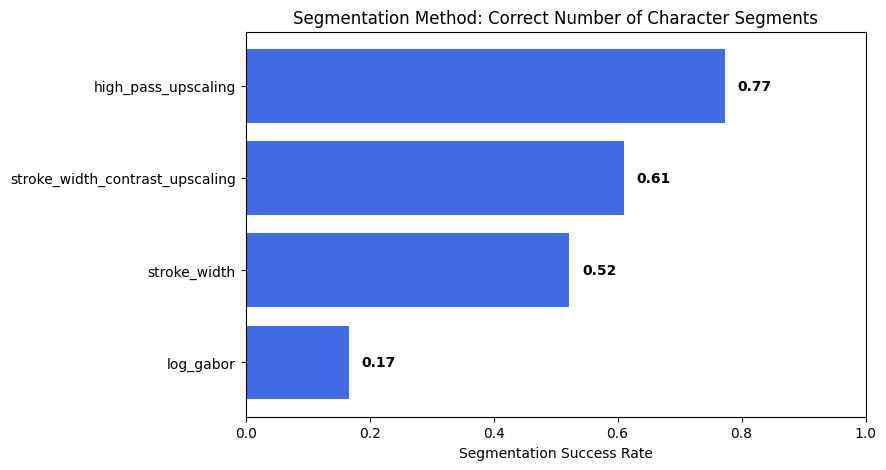

In [3]:
methods = segmentation_df['segmentation_method']
segmentation_success = segmentation_df['accuracy']  # heuristic "accuracy"

plt.figure(figsize=(8,5))
bars = plt.barh(methods, segmentation_success, color='royalblue')
plt.xlim(0, 1)
plt.xlabel("Segmentation Success Rate")
plt.title("Segmentation Method: Correct Number of Character Segments")

# Annotate values on horizontal bars
for bar, val in zip(bars, segmentation_success):
    plt.text(bar.get_width() + 0.02,  # x-coordinate just past the bar
             bar.get_y() + bar.get_height()/2,  # y-coordinate center of bar
             f"{val:.2f}",
             va='center', fontweight='bold')

plt.show()
